In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sbhatti_financial_sentiment_analysis_path = kagglehub.dataset_download('sbhatti/financial-sentiment-analysis')

print('Data source import complete.')


100%|██████████| 276k/276k [00:00<00:00, 62.6MB/s]

Extracting files...
Data source import complete.


# Financial Sentiment Analysis

## Context

* The goal of this notebook is to classify texts related to finance into three sentiment classes: positive, neutral, negative.

### Data

* This [dataset](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis) comes from Kaggle with the following description:

**Data**

* The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels.

**Citations**

* Malo, Pekka, et al. "Good debt or bad debt: Detecting semantic orientations in economic texts." Journal of the Association for Information Science and Technology 65.4 (2014): 782-796.

### Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1. Exploratory Data Analysis

In [3]:
data = pd.read_csv(f"{sbhatti_financial_sentiment_analysis_path}/data.csv")

In [4]:
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### Examples of the three types of sentiment

In [5]:
print("Example of positive financial text:\n\n" ,data[data.Sentiment == 'positive']['Sentence'].sample().iloc[0])

Example of positive financial text:

 Commission income rose by 25.7 % to EUR 16.1 mn from EUR 12.8 mn in 2004 .


In [6]:
print("Example of neutral financial text:\n\n" ,data[data.Sentiment == 'neutral']['Sentence'].sample().iloc[0])

Example of neutral financial text:

 According to Soosalu , particular attention was paid to residents privacy and security in the design of the Aleksandri Street building .


In [7]:
print("Example of negative financial text:\n\n" ,data[data.Sentiment == 'negative']['Sentence'].sample().iloc[0])

Example of negative financial text:

 Sales in Finland decreased by 2.0 % , and international sales decreased by 9.3 % in terms of euros , and by 15.1 % in terms of local currencies .


### General information

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [9]:
data.describe(include='all')

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


* It seems a lot of sentences are duplicates with 5842 total sentences and only 5322 unique ones. This should be investigated thoroughly along with missing values.

### First cleaning operation

* Since the two columns are suposed to contain only strings, let's remove trailing spaces and fill potential NaN values with empty string.

In [10]:
data["Sentiment"] = data["Sentiment"].str.strip()
data["Sentence"] = data["Sentence"].str.strip()

data["Sentiment"] = data["Sentiment"].fillna('')
data["Sentence"] = data["Sentence"].fillna('')

### Missing values

In [11]:
data.isna().sum()

,0
Sentence,0
Sentiment,0


In [12]:
len(data[data["Sentence"] == ''])

0

In [13]:
len(data[data["Sentiment"] == ''])

0

* It seems there are no value missing.

### Duplicates

In [14]:
print("Number of duplicates ", int(data.duplicated().sum()))
print("Percentage of duplicates ", round(100*int(data.duplicated().sum()) / len(data), 2), "%")

Number of duplicates  6
Percentage of duplicates  0.1 %


In [15]:
data[data.duplicated()]

,Sentence,Sentiment
1825,Proha Plc ( Euronext :7327 ) announced today (...,neutral
1859,SSH Communications Security Corporation is hea...,neutral
2672,Ahlstrom 's share is quoted on the NASDAQ OMX ...,neutral
3272,The company serves customers in various indust...,neutral
3986,The issuer is solely responsible for the conte...,neutral
5342,The report profiles 614 companies including ma...,neutral


* Since these are non empty sentences and there is no ambiguity in the nature of the duplicates, it's better to remove them.

In [16]:
data.drop_duplicates(inplace=True)

In [17]:
data[data.duplicated()]

,Sentence,Sentiment


* Full duplicates are now removed. However there seems to be a lot more sentences duplicated and thus having different labels so let's analyse these.

In [18]:
data[data.Sentence.duplicated()].describe()

,Sentence,Sentiment
count,514,514
unique,514,2
top,Finnish GeoSentric 's net sales decreased to E...,negative
freq,1,268


In [19]:
data[data.Sentence.duplicated()]['Sentiment'].value_counts()

,count
Sentiment,
negative,268
neutral,246


In [20]:
duplicate_sentences = data[data.Sentence.duplicated(keep=False)]['Sentence'].unique()

In [21]:
duplicate_counts = data['Sentence'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]
occurrence_summary = duplicate_counts.value_counts().sort_index()
occurrence_summary

,count
count,
2,514


* It seems there are still some duplicates that were not found before since there are two classes, they don't have the same proportion and each sentence appear only twice.

* Before making a choice regarding these duplicates, let's get some idea of class imbalance.

### Class distribution

In [22]:
(data['Sentiment'].value_counts(normalize=True) * 100).map('{:.2f}%'.format)

,proportion
Sentiment,
neutral,53.53%
positive,31.73%
negative,14.74%


In [23]:
data['Sentiment'].value_counts()

,count
Sentiment,
neutral,3124
positive,1852
negative,860


* The classes are very imbalanced and this is something to consider later when building models.

* Is it better to even out the proportions?

* Do these proportions reflect the natural proportion of financial text generated by human writing?

* In light of these new information, it can be a good idea to keep the duplicates classified as negative when the other item in the df is classified as neutral since the majority class is neutral and minority class is negative.

* However it must be noted that the assumption is made that in case of double annotations both classes are more or less accurate and could be interpreted as ambiguous.

* Ideally one should analyse each of the 514 duplicates to validate this hypothesis but it is too time consuming in the context of this project.

* It is also important to note that the task of sentiment analysis with three classes can be inherently ambiguous and lead to bias if the annotation process is not done properly. In any case, it is still a task for which the boundary between classes is not always clear.

In [24]:
duplicated_mask = data.Sentence.duplicated(keep=False)
duplicated_data = data[duplicated_mask].copy()

final_duplicates = []
for sentence in duplicated_data.Sentence.unique():
    group = duplicated_data[duplicated_data.Sentence == sentence]
    negative_rows = group[group['Sentiment'] == 'negative']
    if len(negative_rows) > 0:
        final_duplicates.append(negative_rows.iloc[0])

final_duplicates = pd.DataFrame(final_duplicates) if final_duplicates else pd.DataFrame(columns=data.columns)

data = pd.concat([
    data[~duplicated_mask],
    final_duplicates
])

In [25]:
data.shape

(5322, 2)

* Let's see the resulting proportion in classes.

In [26]:
(data['Sentiment'].value_counts(normalize=True) * 100).map('{:.2f}%'.format)

,proportion
Sentiment,
neutral,49.04%
positive,34.80%
negative,16.16%


In [27]:
data['Sentiment'].value_counts()

,count
Sentiment,
neutral,2610
positive,1852
negative,860


### EDA Visualization

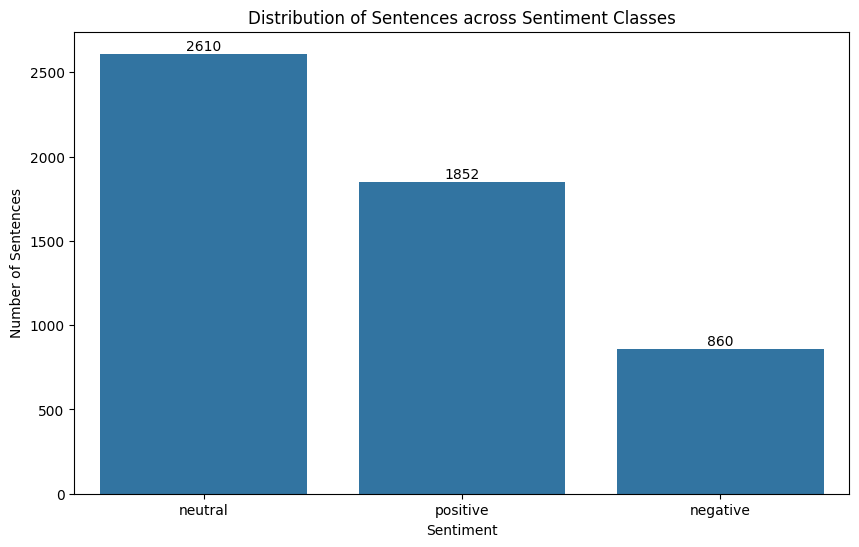

In [28]:
sentiment_counts = data['Sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

plt.title('Distribution of Sentences across Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Number of Sentences')

for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

## 2. Model Building

In [29]:
!pip install -U sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.7/268.7 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: sentence_transformers
    Found existing installation: sentence-transformers 3.2.1
    Uninstalling sentence-transformers-3.2.1:
      Successfully uninstalled sentence-transformers-3.2.1


### Clean the text

In [30]:
import re

def clean_sentence(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s,.!?\-#@]', '', text)
    return cleaned_text

data["Sentence"] = data["Sentence"].apply(lambda x: clean_sentence(x))

In [31]:
df_weight_loss = data.copy()

### Training and evaluation with cross validation pipeline

In [32]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from tqdm import tqdm, trange
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def create_embeddings(texts, model_name='all-MiniLM-L6-v2'):
    embedding_model = SentenceTransformer(model_name)
    embeddings = embedding_model.encode(texts,
                                        batch_size=32,
                                        show_progress_bar=True,
                                        clean_up_tokenization_spaces=True)
    return embeddings

def prepare_data(data):

    le = LabelEncoder()
    data['SentimentEncoded'] = le.fit_transform(data['Sentiment'])

    embeddings = create_embeddings(data['Sentence'].values)

    X_train, X_temp, y_train, y_temp = train_test_split(
        embeddings, data['SentimentEncoded'], test_size=0.3, random_state=RANDOM_SEED, stratify=data['SentimentEncoded']
    )
    X_dev, X_test, y_dev, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp
    )

    return X_train, X_dev, X_test, y_train, y_dev, y_test, le

def train_model(X_train, y_train, X_dev, y_dev, cv_folds=5):

    params = {
        'max_depth': 6,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 0.7,
        'objective': 'multi:softprob',
        'random_state': RANDOM_SEED,
        #'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    f1_scores = []

    num_fold = 1
    for train_index, test_index in skf.split(X_train, y_train):

        model = xgb.XGBClassifier(**params)

        if isinstance(X_train, pd.DataFrame):
            X_train_cv = X_train.iloc[train_index]
            X_test_cv = X_train.iloc[test_index]
        else:
            X_train_cv = X_train[train_index]
            X_test_cv = X_train[test_index]

        if isinstance(y_train, pd.Series):
            y_train_cv = y_train.iloc[train_index]
            y_test_cv = y_train.iloc[test_index]
        else:
            y_train_cv = y_train[train_index]
            y_test_cv = y_train[test_index]

        model.fit(X_train_cv, y_train_cv, eval_set=[(X_test_cv, y_test_cv)], verbose=False)

        y_pred_cv = model.predict(X_test_cv)

        f1 = f1_score(y_test_cv, y_pred_cv, average='macro')
        f1_scores.append(f1)
        print(f"F1 Score for fold {num_fold}: {f1:.4f}")
        num_fold += 1

    print(f"Mean F1 Score across all folds: {np.mean(f1_scores):.4f}")

    final_model = xgb.XGBClassifier(**params)

    final_model.fit(X_train, y_train, eval_set=[(X_dev, y_dev)], verbose=True)

    return final_model

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("F1 Score (Macro):", f1)
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    print(f"F1 Score (Micro): {micro_f1:.4f}")
    print("\nClassification Report:\n", report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_proba = model.predict_proba(X_test)

    plt.figure(figsize=(10, 8))
    for i, class_label in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

def run_pipeline(data):

    X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder = prepare_data(data)

    best_model = train_model(X_train, y_train, X_dev, y_dev)

    evaluate_model(best_model, X_dev, y_dev, label_encoder)
    #evaluate_model(best_model, X_test, y_test, label_encoder)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/167 [00:00<?, ?it/s]

F1 Score for fold 1: 0.6892
F1 Score for fold 2: 0.7085
F1 Score for fold 3: 0.7510
F1 Score for fold 4: 0.7165
F1 Score for fold 5: 0.7444
Mean F1 Score across all folds: 0.7219
[0]	validation_0-mlogloss:1.07767
[1]	validation_0-mlogloss:1.05948
[2]	validation_0-mlogloss:1.04028
[3]	validation_0-mlogloss:1.02175
[4]	validation_0-mlogloss:1.00574
[5]	validation_0-mlogloss:0.99078
[6]	validation_0-mlogloss:0.97551
[7]	validation_0-mlogloss:0.96211
[8]	validation_0-mlogloss:0.94988
[9]	validation_0-mlogloss:0.93765
[10]	validation_0-mlogloss:0.92543
[11]	validation_0-mlogloss:0.91544
[12]	validation_0-mlogloss:0.90401
[13]	validation_0-mlogloss:0.89366
[14]	validation_0-mlogloss:0.88355
[15]	validation_0-mlogloss:0.87390
[16]	validation_0-mlogloss:0.86498
[17]	validation_0-mlogloss:0.85607
[18]	validation_0-mlogloss:0.84794
[19]	validation_0-mlogloss:0.83842
[20]	validation_0-mlogloss:0.83096
[21]	validation_0-mlogloss:0.82389
[22]	validation_0-mlogloss:0.81620
[23]	validation_0-mlogloss

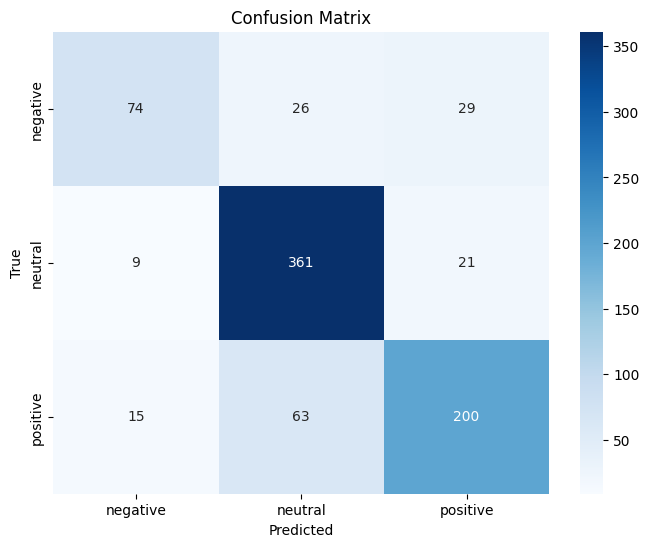

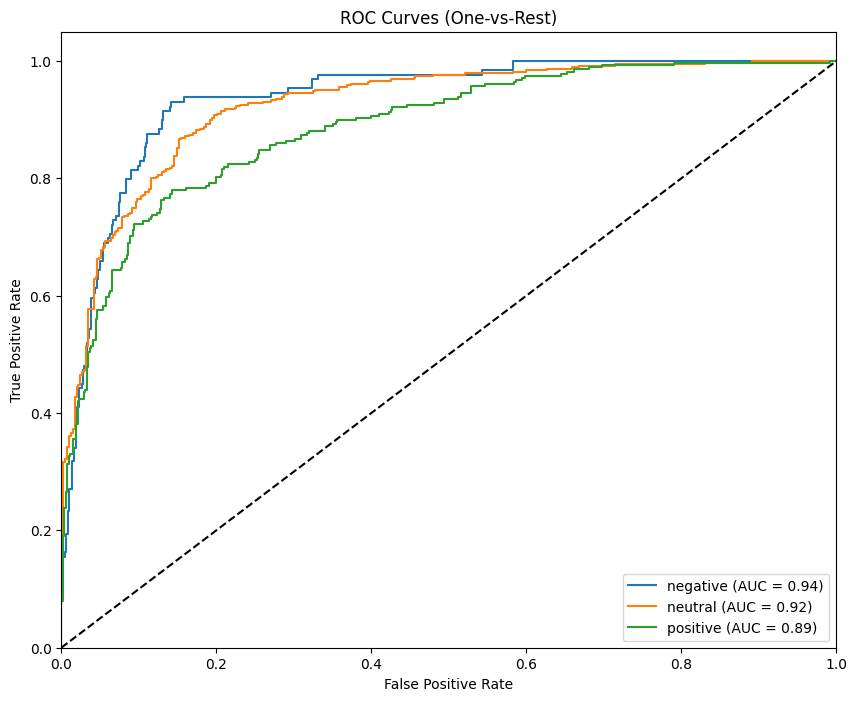

In [33]:
run_pipeline(data)

## 3. Interpretation



*   The results are encouraging in the sense that the accuracy is around 80% and the AUC scores for the three classes are quite high and around or more than 0.9. The AUC score gives insights in the form of a probability indicating the extent to which the model is able to dicriminate each particular class from other classes.
*   There is an obvious performance imbalance between the three classes that is likely due to the class imbalance in the dataset and the potential ambiguity with the neutral class and its interactions with the other two classes. That said the minority class is actually the one with the highest score and the middle class positive is the lowest.
*The next step could be to work around or fix class imbalance, with techniques such as weighting the classes differently when it comes to the loss function based on their frequency, which we will cover next.



## 4. Weight classes differently based on their frequency

In [37]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm, trange
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def create_embeddings(texts, model_name='all-MiniLM-L6-v2'):
    embedding_model = SentenceTransformer(model_name)
    embeddings = embedding_model.encode(texts,
                                      batch_size=32,
                                      show_progress_bar=True,
                                      clean_up_tokenization_spaces=True)
    return embeddings

def calculate_class_weights(y, weight_strategy='balanced'):

    unique_classes = np.unique(y)
    if weight_strategy == 'balanced':
        weights = compute_class_weight('balanced', classes=unique_classes, y=y)
    elif weight_strategy == 'sqrt_balanced':
        counts = np.bincount(y)
        weights = np.sqrt(len(y) / (len(unique_classes) * counts[unique_classes]))
    elif weight_strategy == 'log_balanced':
        counts = np.bincount(y)
        weights = np.log1p(len(y) / (len(unique_classes) * counts[unique_classes]))
    else:
        raise ValueError("Invalid weight_strategy")

    return dict(zip(unique_classes, weights))

def prepare_data(data):
    le = LabelEncoder()
    data['SentimentEncoded'] = le.fit_transform(data['Sentiment'])

    embeddings = create_embeddings(data['Sentence'].values)

    X_train, X_temp, y_train, y_temp = train_test_split(
        embeddings, data['SentimentEncoded'], test_size=0.3, random_state=RANDOM_SEED, stratify=data['SentimentEncoded']
    )
    X_dev, X_test, y_dev, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp
    )

    return X_train, X_dev, X_test, y_train, y_dev, y_test, le

def train_model(X_train, y_train, X_dev, y_dev, le, cv_folds=5, weight_strategy='balanced'):

    class_weights = calculate_class_weights(y_train, weight_strategy)
    print(f"\nUsing class weights: {class_weights}")

    class_weights_with_names = {le.inverse_transform([cls])[0]: weight for cls, weight in class_weights.items()}
    print(f"\nUsing class weights (with names): {class_weights_with_names}")

    sample_weights = np.array([class_weights[label] for label in y_train])

    params = {
        'max_depth': 6,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 0.7,
        'objective': 'multi:softprob',
        'random_state': RANDOM_SEED,
        #'use_label_encoder': False,
        'eval_metric': 'mlogloss'
    }

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_SEED)
    f1_scores = []

    print("\nPerforming cross-validation...")
    num_fold = 1
    for train_index, test_index in skf.split(X_train, y_train):
        model = xgb.XGBClassifier(**params)

        if isinstance(X_train, pd.DataFrame):
            X_train_cv = X_train.iloc[train_index]
            X_test_cv = X_train.iloc[test_index]
        else:
            X_train_cv = X_train[train_index]
            X_test_cv = X_train[test_index]

        if isinstance(y_train, pd.Series):
            y_train_cv = y_train.iloc[train_index]
            y_test_cv = y_train.iloc[test_index]
            sample_weights_cv = sample_weights[train_index]
        else:
            y_train_cv = y_train[train_index]
            y_test_cv = y_train[test_index]
            sample_weights_cv = sample_weights[train_index]

        model.fit(
            X_train_cv,
            y_train_cv,
            sample_weight=sample_weights_cv,
            eval_set=[(X_test_cv, y_test_cv)],
            verbose=False
        )

        y_pred_cv = model.predict(X_test_cv)
        f1 = f1_score(y_test_cv, y_pred_cv, average='macro')
        f1_scores.append(f1)
        print(f"F1 Score for fold {num_fold}: {f1:.4f}")
        num_fold += 1

    print(f"\nMean F1 Score across all folds: {np.mean(f1_scores):.4f}")

    print("\nTraining final model...")
    final_model = xgb.XGBClassifier(**params)
    final_model.fit(
        X_train,
        y_train,
        sample_weight=sample_weights,
        eval_set=[(X_dev, y_dev)],
        verbose=True
    )

    return final_model, class_weights

def evaluate_model(model, X_test, y_test, label_encoder, class_weights):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_test, y_pred)

    print("\nEvaluation Results:")
    print(f"Used class weights: {class_weights}")
    class_weights_with_names = {label_encoder.inverse_transform([cls])[0]: weight for cls, weight in class_weights.items()}
    print(f"\nUsing class weights (with names): {class_weights_with_names}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    print(f"F1 Score (Micro): {micro_f1:.4f}")
    print("\nClassification Report:\n", report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_proba = model.predict_proba(X_test)

    plt.figure(figsize=(10, 8))
    for i, class_label in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

def run_pipeline(data, weight_strategy='balanced'):

    print(f"Running pipeline with {weight_strategy} class weights...")

    X_train, X_dev, X_test, y_train, y_dev, y_test, label_encoder = prepare_data(data)

    best_model, class_weights = train_model(
        X_train, y_train, X_dev, y_dev, label_encoder,
        weight_strategy=weight_strategy
    )

    evaluate_model(best_model, X_dev, y_dev, label_encoder, class_weights)

Running pipeline with log_balanced class weights...


Batches:   0%|          | 0/167 [00:00<?, ?it/s]


Using class weights: {0: 1.1192541760177472, 1: 0.5185678793310703, 2: 0.6719624257258829}

Using class weights (with names): {'negative': 1.1192541760177472, 'neutral': 0.5185678793310703, 'positive': 0.6719624257258829}

Performing cross-validation...
F1 Score for fold 1: 0.6900
F1 Score for fold 2: 0.7305
F1 Score for fold 3: 0.7639
F1 Score for fold 4: 0.7296
F1 Score for fold 5: 0.7373

Mean F1 Score across all folds: 0.7303

Training final model...
[0]	validation_0-mlogloss:1.07928
[1]	validation_0-mlogloss:1.06117
[2]	validation_0-mlogloss:1.04385
[3]	validation_0-mlogloss:1.02722
[4]	validation_0-mlogloss:1.01116
[5]	validation_0-mlogloss:0.99644
[6]	validation_0-mlogloss:0.98310
[7]	validation_0-mlogloss:0.96991
[8]	validation_0-mlogloss:0.95758
[9]	validation_0-mlogloss:0.94627
[10]	validation_0-mlogloss:0.93482
[11]	validation_0-mlogloss:0.92321
[12]	validation_0-mlogloss:0.91258
[13]	validation_0-mlogloss:0.90204
[14]	validation_0-mlogloss:0.89214
[15]	validation_0-mloglos

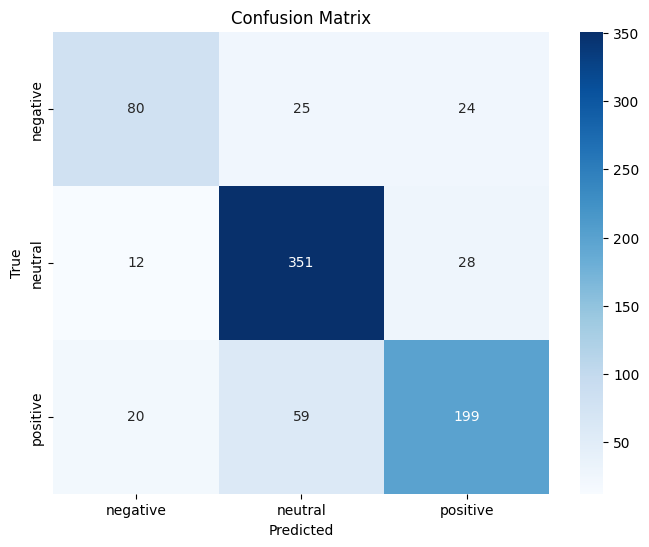

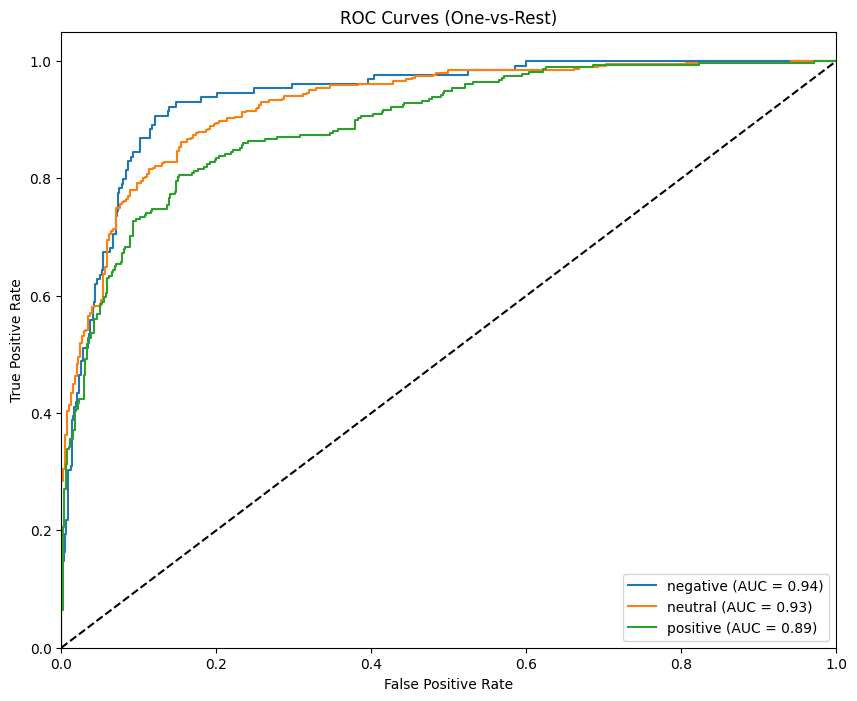

In [38]:
run_pipeline(df_weight_loss, weight_strategy='log_balanced')

## 5. Next steps



*   The results de not really change when weighting the classes differently at training time based on their frequency.
*   It could be interesting to see if changing their frequency based on their performance instead could lead to a more balanced model.
*   Next we will try different models to compare.
*   The following part will feature finetuning BERT for embedding the sentences (using the BOS token that can give a good representation of the text) along with a MLP.
* Then it would be interesting to try Llama 3.2 for this sentiment analysis task.



## 6. BERT-based sentiment analysis (TODO)